# 1. Data preparation
Gridded inputs: GRACE ΔTWS, TerraClimate precipitation and evapotranspiration, MODIS NDVI, MERIT DEM elevation


In [1]:
import geopandas as gpd
import numpy as np
import ee
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import shape
from rasterio.enums import Resampling
from utils.interpolation import griddata_interpolation

In [2]:
# trigger the GEE authentication flow.
ee.Authenticate()
# initialize the library.
ee.Initialize(project='ee-pazolka')

root_path = './data/Bangladesh/'
input_path = f'{root_path}/inputs'

In [3]:
bgd_shp = gpd.read_file(f'{root_path}/BGD_shp/vb025yv7599.shp')

In [4]:
s_date = '2002-04-01'
e_date = '2017-05-31'

# bounding box around Bangladesh
bounds = ee.Geometry.Polygon([
    [87.24,20.70],
    [93.25,20.70],
    [93.25,26.60],
    [87.24,26.60],
    [87.24,20.70]
])

#### 1. Get NDVI
Data from GEE

In [5]:
modis = ee.ImageCollection('MODIS/061/MOD13A3') \
    .filterDate(s_date, e_date) \
    .filterBounds(bounds)

ndvi_2 = modis.select('NDVI')

# Apply the scaling factor
ee_ndvi = ndvi_2.map(lambda i: i.multiply(0.0001).copyProperties(i, i.propertyNames()))

ndvi_ds = xr.open_dataset(
    ee_ndvi,
    engine='ee',
    geometry=bounds,
    crs='EPSG:4326',
    scale=0.25
).transpose('time','lat', 'lon')

In [6]:
ndvi_ds = ndvi_ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
ndvi_ds = ndvi_ds.rio.write_crs('epsg:4326', inplace=True)

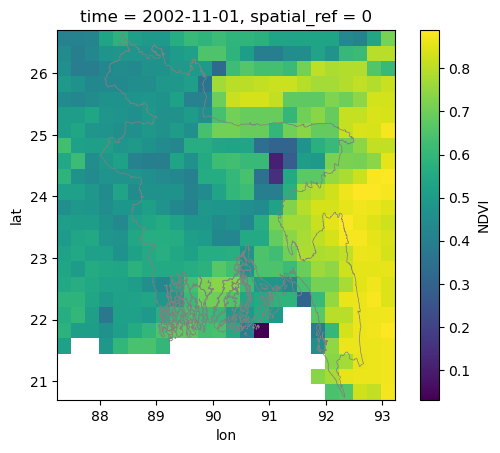

In [7]:
bgd_shp.boundary.plot(color='gray', linewidth=0.5)
ndvi_ds['NDVI'][7].plot()

In [8]:
# interpolate terraclimate to fill small gaps along the shore

x = ndvi_ds['lon'].values
y = ndvi_ds['lat'].values

filled_das = []

for t in range(0, ndvi_ds['NDVI'].shape[0]):
    print(f'Interpolating timestep: {t}')
    var = ndvi_ds['NDVI'][t].values
    filled_var = griddata_interpolation(x,y,var)[np.newaxis, ...]
    pr_t_da = xr.DataArray(filled_var,
        coords={'time': [ndvi_ds.time[t].values], 'lon': x, 'lat': y},
        dims = ['time', 'lat', 'lon'])
    filled_das.append(pr_t_da)

ipol_ndvi_da = xr.concat(filled_das, 'time')
ipol_ndvi_da.rio.write_nodata(np.nan, inplace=True)
ipol_ndvi_ds = ipol_ndvi_da.to_dataset(name='NDVI')

ipol_ndvi_da.rio.write_nodata(np.nan, inplace=True)

Interpolating timestep: 0
Interpolating timestep: 1
Interpolating timestep: 2
Interpolating timestep: 3
Interpolating timestep: 4
Interpolating timestep: 5
Interpolating timestep: 6
Interpolating timestep: 7
Interpolating timestep: 8
Interpolating timestep: 9
Interpolating timestep: 10
Interpolating timestep: 11
Interpolating timestep: 12
Interpolating timestep: 13
Interpolating timestep: 14
Interpolating timestep: 15
Interpolating timestep: 16
Interpolating timestep: 17
Interpolating timestep: 18
Interpolating timestep: 19
Interpolating timestep: 20
Interpolating timestep: 21
Interpolating timestep: 22
Interpolating timestep: 23
Interpolating timestep: 24
Interpolating timestep: 25
Interpolating timestep: 26
Interpolating timestep: 27
Interpolating timestep: 28
Interpolating timestep: 29
Interpolating timestep: 30
Interpolating timestep: 31
Interpolating timestep: 32
Interpolating timestep: 33
Interpolating timestep: 34
Interpolating timestep: 35
Interpolating timestep: 36
Interpolati

<xarray.DataArray (time: 182, lat: 24, lon: 24)> Size: 419kB
array([[[   nan,    nan,    nan, ..., 0.5354, 0.5538, 0.5371],
        [   nan,    nan,    nan, ..., 0.7124, 0.7124, 0.6317],
        [   nan,    nan,    nan, ..., 0.7202, 0.6438, 0.6815],
        ...,
        [0.3282, 0.3304, 0.3304, ..., 0.5588, 0.5122, 0.4535],
        [0.3525, 0.3447, 0.3821, ..., 0.5264, 0.6615, 0.6615],
        [0.454 , 0.454 , 0.4558, ..., 0.3942, 0.4338, 0.4499]],

       [[   nan,    nan,    nan, ..., 0.6191, 0.6499, 0.6157],
        [   nan,    nan,    nan, ..., 0.7446, 0.7446, 0.6957],
        [   nan,    nan,    nan, ..., 0.7536, 0.7052, 0.738 ],
        ...,
        [0.426 , 0.4432, 0.4432, ..., 0.6343, 0.6069, 0.5519],
        [0.3978, 0.3913, 0.476 , ..., 0.6114, 0.7534, 0.7534],
        [0.5399, 0.5399, 0.5417, ..., 0.449 , 0.4999, 0.519 ]],

       [[   nan,    nan,    nan, ..., 0.6878, 0.7023, 0.659 ],
        [   nan,    nan,    nan, ..., 0.7814, 0.7814, 0.7567],
        [   nan,    nan,    nan, ..., 0.8056, 0.764 , 0.7853],
        ...,
...
        [0.5926, 0.4631, 0.4631, ..., 0.5177, 0.4402, 0.4135],
        [0.5602, 0.4836, 0.4538, ..., 0.4938, 0.6384, 0.6384],
        [0.4578, 0.4578, 0.4416, ..., 0.3582, 0.3872, 0.416 ]],

       [[   nan,    nan,    nan, ..., 0.6244, 0.6451, 0.5972],
        [   nan,    nan,    nan, ..., 0.7437, 0.7437, 0.6836],
        [   nan,    nan,    nan, ..., 0.7503, 0.7109, 0.7232],
        ...,
        [0.5212, 0.4559, 0.4559, ..., 0.5654, 0.5156, 0.4965],
        [0.4784, 0.4549, 0.4699, ..., 0.5876, 0.6662, 0.6662],
        [0.4832, 0.4832, 0.4811, ..., 0.4205, 0.4551, 0.4782]],

       [[   nan,    nan,    nan, ..., 0.6473, 0.675 , 0.6186],
        [   nan,    nan,    nan, ..., 0.7589, 0.7589, 0.7052],
        [   nan,    nan,    nan, ..., 0.7664, 0.7394, 0.7512],
        ...,
        [0.4897, 0.5107, 0.5107, ..., 0.6609, 0.6124, 0.5957],
        [0.4644, 0.4929, 0.557 , ..., 0.6302, 0.7586, 0.7586],
        [0.5869, 0.5869, 0.5773, ..., 0.4695, 0.5122, 0.528 ]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2002-04-01 2002-05-01 ... 2017-05-01
  * lon      (lon) float64 192B 87.36 87.61 87.86 88.11 ... 92.61 92.86 93.11
  * lat      (lat) float64 192B 20.82 21.07 21.32 21.57 ... 26.07 26.32 26.57
Attributes:
    _FillValue:  nan

#### 2. Get TerraClimate precipitation and evapotranspiration
Data from GEE

In [9]:
terraclimate_raw = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE') \
    .filter(ee.Filter.date(s_date, e_date)) \
    .filterBounds(bounds)

ee_precip = terraclimate_raw.select('pr')
ee_aet = terraclimate_raw.select('aet').map(lambda i: i.multiply(0.1).copyProperties(i, i.propertyNames())) # scaling factor from the docs

terraclimate_ds = xr.open_mfdataset(
    [ee_precip, ee_aet],
    engine='ee',
    projection=ee_aet.first().select(0).projection(),
    geometry=bounds
).transpose('time','lat', 'lon')

In [10]:
# downscale to 0.25 x 0.25
terraclimate_ds['aet'].rio.write_nodata(np.nan, inplace=True)
terraclimate_ds['pr'].rio.write_nodata(np.nan, inplace=True)

terraclimate_ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
terraclimate_ds.rio.write_crs('epsg:4326', inplace=True)

terraclimate_ds = terraclimate_ds.rio.reproject_match(ndvi_ds, resampling=Resampling.bilinear).rename({'x': 'lon','y': 'lat'})

In [11]:
# interpolate terraclimate to fill small gaps along the shore

x = terraclimate_ds['lon'].values
y = terraclimate_ds['lat'].values

filled_das = []

for t in range(0, terraclimate_ds['pr'].shape[0]):
    print(f'Interpolating timestep: {t}')
    var = terraclimate_ds['pr'][t].values
    filled_var = griddata_interpolation(x,y,var)[np.newaxis, ...]
    pr_t_da = xr.DataArray(filled_var,
        coords={'time': [terraclimate_ds.time[t].values], 'lon': x, 'lat': y},
        dims = ['time', 'lat', 'lon'])
    filled_das.append(pr_t_da)

ipol_pr_da = xr.concat(filled_das, 'time')
ipol_pr_da.rio.write_nodata(np.nan, inplace=True)
ipol_pr_ds = ipol_pr_da.to_dataset(name='pr')

filled_das = []

for t in range(0, terraclimate_ds['aet'].shape[0]):
    print(f'Interpolating timestep: {t}')
    var = terraclimate_ds['aet'][t].values
    filled_var = griddata_interpolation(x,y,var)[np.newaxis, ...]
    aet_t_da = xr.DataArray(filled_var,
        coords={'time': [terraclimate_ds.time[t].values], 'lon': x, 'lat': y},
        dims = ['time', 'lat', 'lon'])
    filled_das.append(aet_t_da)

ipol_aet_da = xr.concat(filled_das, 'time')
ipol_aet_da.rio.write_nodata(np.nan, inplace=True)
terraclimate_ds = xr.merge([ipol_aet_da.to_dataset(name='aet'), ipol_pr_ds])

Interpolating timestep: 0
Interpolating timestep: 1
Interpolating timestep: 2
Interpolating timestep: 3
Interpolating timestep: 4
Interpolating timestep: 5
Interpolating timestep: 6
Interpolating timestep: 7
Interpolating timestep: 8
Interpolating timestep: 9
Interpolating timestep: 10
Interpolating timestep: 11
Interpolating timestep: 12
Interpolating timestep: 13
Interpolating timestep: 14
Interpolating timestep: 15
Interpolating timestep: 16
Interpolating timestep: 17
Interpolating timestep: 18
Interpolating timestep: 19
Interpolating timestep: 20
Interpolating timestep: 21
Interpolating timestep: 22
Interpolating timestep: 23
Interpolating timestep: 24
Interpolating timestep: 25
Interpolating timestep: 26
Interpolating timestep: 27
Interpolating timestep: 28
Interpolating timestep: 29
Interpolating timestep: 30
Interpolating timestep: 31
Interpolating timestep: 32
Interpolating timestep: 33
Interpolating timestep: 34
Interpolating timestep: 35
Interpolating timestep: 36
Interpolati

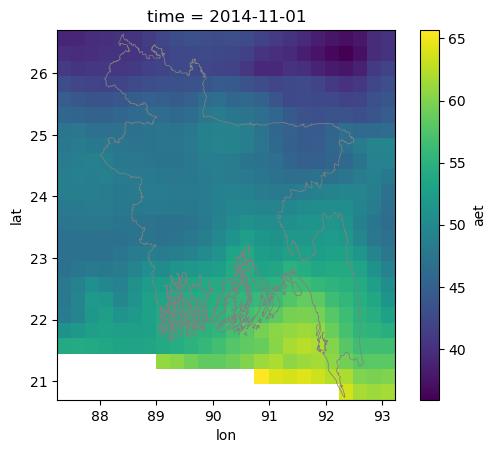

In [12]:
bgd_shp.boundary.plot(color='gray', linewidth=0.5)
terraclimate_ds['aet'][151].plot()

#### 3. Get elevation

In [13]:
merit_dem = ee.Image("MERIT/DEM/v1_0_3").clip(bounds)

dem_ds = xr.open_dataset(
    ee.ImageCollection(merit_dem),
    engine='ee',
    geometry=bounds,
    crs='EPSG:4326',
    scale=0.25
).transpose('time','lat', 'lon')

/home/anna/anaconda3/envs/phd/lib/python3.11/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


In [14]:
dem_ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
dem_ds.rio.write_crs('epsg:4326', inplace=True)

<xarray.Dataset> Size: 3kB
Dimensions:      (time: 1, lat: 24, lon: 24)
Coordinates:
  * time         (time) int64 8B 0
  * lon          (lon) float64 192B 87.36 87.61 87.86 ... 92.61 92.86 93.11
  * lat          (lat) float64 192B 20.82 21.07 21.32 ... 26.07 26.32 26.57
    spatial_ref  int64 8B 0
Data variables:
    dem          (time, lat, lon) float32 2kB ...

#### 4. Get GRACE TWSA

In [15]:
# obtained from https://www2.csr.utexas.edu/grace/RL06_mascons.html
grace_ds = xr.open_mfdataset('./data/CSR_GRACE_GRACE-FO_RL0603_Mascons_all-corrections.nc')
grace_ds

<xarray.Dataset> Size: 1GB
Dimensions:        (time: 247, timebound: 2, lon: 1440, lat: 720)
Coordinates:
  * time           (time) float32 988B 107.0 129.5 227.5 ... 8.567e+03 8.598e+03
  * lon            (lon) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * lat            (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Dimensions without coordinates: timebound
Data variables:
    time_bounds    (time, timebound) float32 2kB dask.array<chunksize=(247, 2), meta=np.ndarray>
    lwe_thickness  (time, lat, lon) float32 1GB dask.array<chunksize=(36, 103, 206), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    filename:                   netcdf/CSR_GRACE_GRACE-FO_RL0603_Mascons_all-...
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    title:                      CSR GRACE and GRACE-FO MASCON RL0603M
    subtitle:                   RL06.3 GRACE/GRACE-FO Total water storage wit...
    ...                         ...
    user_note_3:                Ellipsoidal correction has been applied. The ...
    user_note_4:                This GRACE-FO RL06.3 data is an updated versi...
    date_created:               2025-09-22T10:11:28Z
    variable:                   liquid water equivalent thickness
    label:                      RL0603rc24cE
    Mask:                       Global

In [16]:
global_twsa_da = grace_ds['lwe_thickness'] * 10 # converting from cm to mm

# slightly extending upper lat bound to make sure that reprojected grid covers the entire domain
bounds = ee.Geometry.Polygon([
    [87.24,20.70],
    [93.25,20.70],
    [93.25,27.0],
    [87.24,27.0],
    [87.24,20.70]
])

# setting time dims to datetime
ref_time = pd.to_datetime(grace_ds.attrs['time_epoch'])
new_time = [ ref_time + pd.DateOffset(days=t) for t in global_twsa_da.time ]
global_twsa_da = global_twsa_da.assign_coords(time=new_time)
global_twsa_da['time'] = global_twsa_da['time'].astype('datetime64[ns]')

# clipping
global_twsa_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
global_twsa_da.rio.write_crs('epsg:4326', inplace=True)
regional_twsa_da = global_twsa_da.rio.clip([shape(bounds.getInfo())], global_twsa_da.rio.crs)

# clip time
regional_twsa_da = regional_twsa_da.sel(time=slice(None, '2017-05-30'))

In [17]:
# download link: https://download.csr.utexas.edu/outgoing/grace/RL0603_mascons/CSR_GRACE_GRACE-FO_RL06_Mascons_v02_LandMask.nc
land_mask = xr.open_dataset('./data/CSR_GRACE_GRACE-FO_RL06_Mascons_v02_LandMask.nc')
land_mask.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
land_mask.rio.write_crs('epsg:4326', inplace=True)
land_mask = land_mask.rio.clip([shape(bounds.getInfo())], land_mask.rio.crs)

In [18]:
twsa_da = regional_twsa_da.where(land_mask).rename_vars({'LO_val': 'twsa'})['twsa']

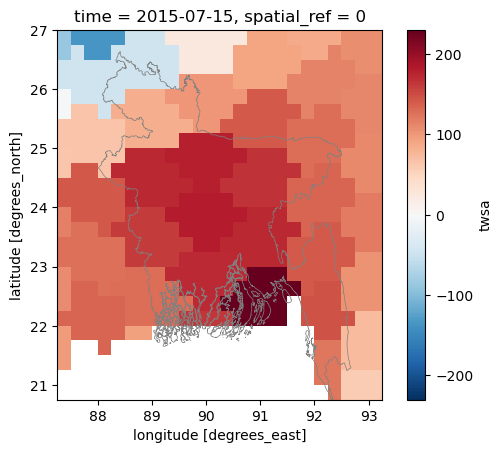

In [19]:
bgd_shp.boundary.plot(color='gray', linewidth=0.5)
twsa_da[145].plot()

In [20]:
twsa_da_before_interpol = twsa_da.mean(dim=['lat', 'lon'])

In [21]:
# shift the reported value from 01.01.2012 to 01.12.2011 and from 27.04.2015 to 01.05.2015 - manual fix for dupliate values reported for 01.2012 and 04.2015
twsa_da['time'].values[110] = pd.Timestamp(twsa_da['time'].values[110]) - pd.DateOffset(days=1)
twsa_da['time'].values[144] = pd.Timestamp(twsa_da['time'].values[144]) + pd.DateOffset(days=3)

resampled_twsa_da = twsa_da.resample(time='MS').asfreq()
resampled_twsa_da.rio.write_nodata(np.nan, inplace=True)

filled_twsa_da = resampled_twsa_da.chunk(time=-1).interpolate_na(dim='time', method='linear')

In [22]:
twsa_da_after_interpol = filled_twsa_da.mean(dim=['lat', 'lon'])

In [23]:
# interpolate GRACE to fill small gaps along the shore
x = filled_twsa_da['lon'].values
y = filled_twsa_da['lat'].values

filled_das = []

for t in range(0, filled_twsa_da.shape[0]):
    print(f'Interpolating timestep: {t}')
    var = filled_twsa_da[t].values
    filled_var = griddata_interpolation(x,y,var)[np.newaxis, ...]
    twsa_t_da = xr.DataArray(filled_var,
        coords={'time': [filled_twsa_da.time[t].values], 'lon': x, 'lat': y},
        dims = ['time', 'lat', 'lon'])
    filled_das.append(twsa_t_da)

# Create new xarray dataset
ipol_twsa_da = xr.concat(filled_das, 'time')
ipol_twsa_da.rio.write_nodata(np.nan, inplace=True)
ipol_twsa_ds = ipol_twsa_da.to_dataset(name='twsa')

Interpolating timestep: 0
Interpolating timestep: 1
Interpolating timestep: 2
Interpolating timestep: 3
Interpolating timestep: 4
Interpolating timestep: 5
Interpolating timestep: 6
Interpolating timestep: 7
Interpolating timestep: 8
Interpolating timestep: 9
Interpolating timestep: 10
Interpolating timestep: 11
Interpolating timestep: 12
Interpolating timestep: 13
Interpolating timestep: 14
Interpolating timestep: 15
Interpolating timestep: 16
Interpolating timestep: 17
Interpolating timestep: 18
Interpolating timestep: 19
Interpolating timestep: 20
Interpolating timestep: 21
Interpolating timestep: 22
Interpolating timestep: 23
Interpolating timestep: 24
Interpolating timestep: 25
Interpolating timestep: 26
Interpolating timestep: 27
Interpolating timestep: 28
Interpolating timestep: 29
Interpolating timestep: 30
Interpolating timestep: 31
Interpolating timestep: 32
Interpolating timestep: 33
Interpolating timestep: 34
Interpolating timestep: 35
Interpolating timestep: 36
Interpolati

In [24]:
twsa_da_after_spinterpo = ipol_twsa_da.where(~np.isnan(filled_twsa_da), np.nan).mean(dim=['lat', 'lon'])

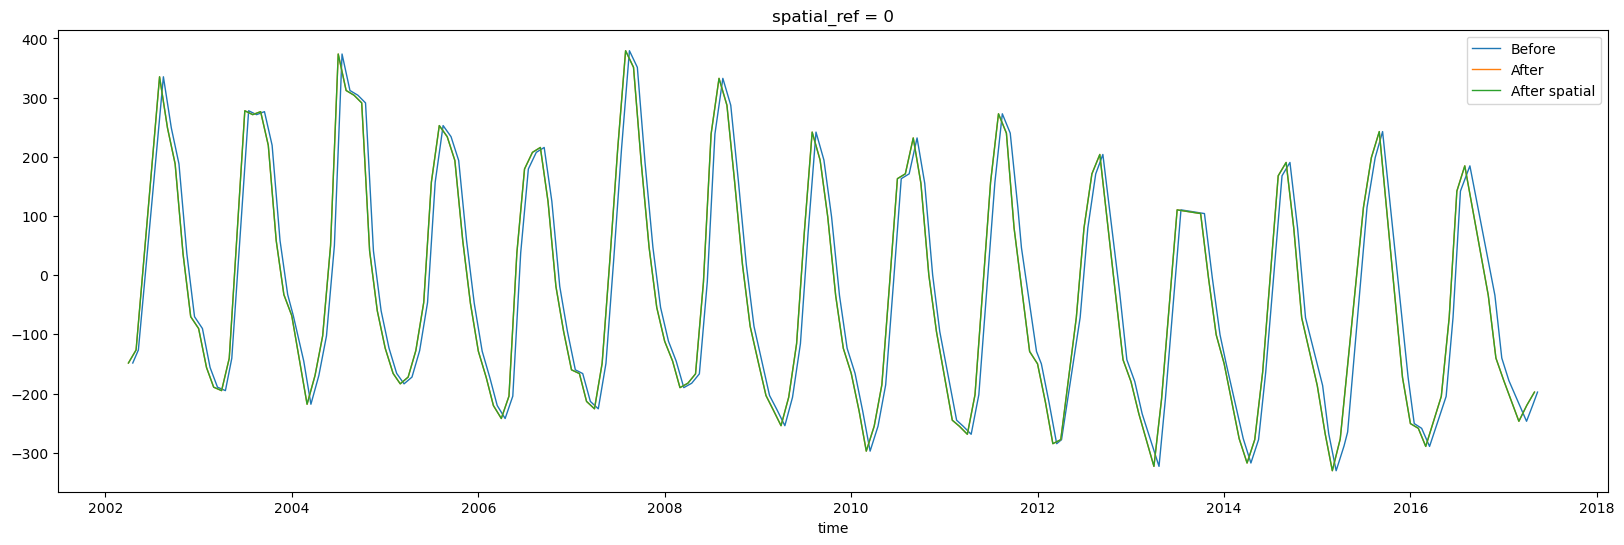

In [25]:
plt.figure(figsize=(20,6))

twsa_da_before_interpol.plot(label="Before", linewidth=1)
twsa_da_after_interpol.plot(label="After", linewidth=1)
twsa_da_after_spinterpo.plot(label="After spatial", linewidth=1)

plt.legend()

plt.savefig('./figs/grace_spatial_interpol_check.png')

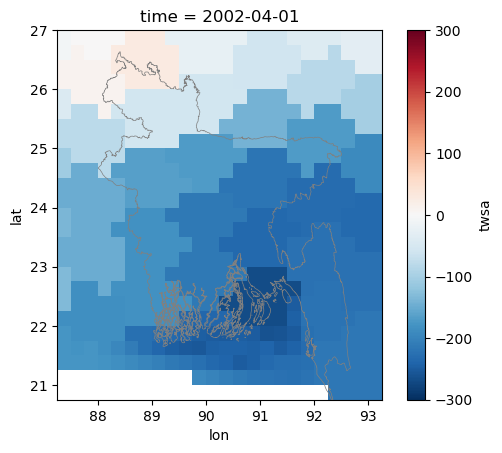

In [26]:
bgd_shp.boundary.plot(color='gray', linewidth=0.5)
ipol_twsa_ds.twsa[0].plot(vmin=-300, vmax=300, cmap='RdBu_r')

In [27]:
# upscale to 0.25 x 0.25
ipol_twsa_ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
ipol_twsa_ds.rio.write_crs('epsg:4326', inplace=True)
resampled_filled_twsa_ds = ipol_twsa_ds.rio.reproject_match(ndvi_ds).rename({'x': 'lon','y': 'lat'})

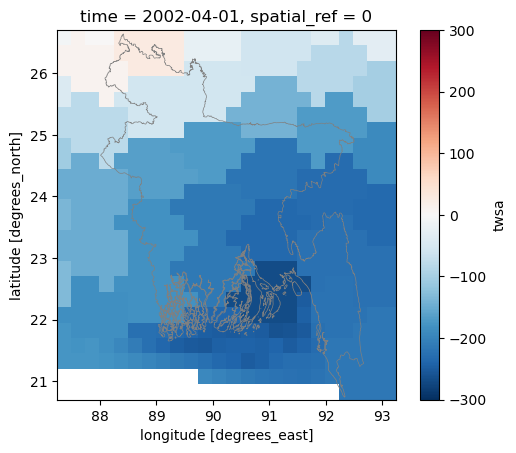

In [28]:
bgd_shp.boundary.plot(color='gray', linewidth=0.5)
resampled_filled_twsa_ds['twsa'][0].plot(vmin=-300, vmax=300, cmap='RdBu_r')

#### 5. Save input for the whole region (bounding box)

In [29]:
# define ocean mask
ocean_mask = np.isnan(resampled_filled_twsa_ds['twsa'][0]) | np.isnan(terraclimate_ds['pr'][0]) \
    | np.isnan(dem_ds['dem'][0]) 

ipol_ndvi_ds['NDVI'] = ipol_ndvi_ds['NDVI'].where(~ocean_mask, other=np.nan)
terraclimate_ds['pr'] = terraclimate_ds['pr'].where(~ocean_mask, other=np.nan)
terraclimate_ds['aet'] = terraclimate_ds['aet'].where(~ocean_mask, other=np.nan)
dem_ds['dem'] = dem_ds['dem'].where(~ocean_mask, other=np.nan)
resampled_filled_twsa_ds['twsa'] = resampled_filled_twsa_ds['twsa'].where(~ocean_mask, other=np.nan)

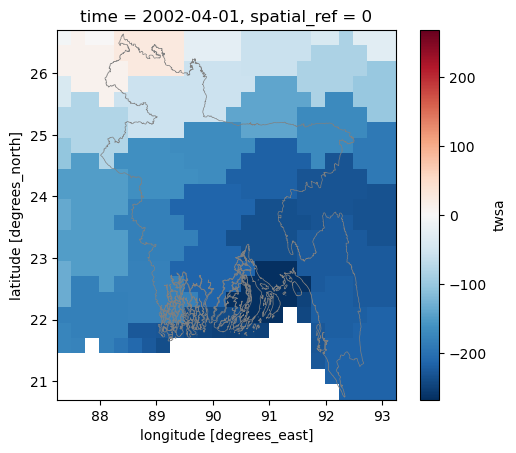

In [30]:
bgd_shp.boundary.plot(color='gray', linewidth=0.5)
resampled_filled_twsa_ds['twsa'][0].plot()

In [31]:
# # save input grid (bounding box)
ipol_ndvi_ds.to_netcdf(f'{input_path}/NDVI_M_2002_2017_BGD_025.nc4') # NDVI
terraclimate_ds.to_netcdf(f'{input_path}/PR_AET_M_2002_2017_BGD_025.nc4') # P and ET
dem_ds.to_netcdf(f'{input_path}/DEM_BGD_025.nc4') # DEM
resampled_filled_twsa_ds.to_netcdf((f'{input_path}/TWSA_M_2002_2017_BGD_025.nc4')) # GRACE TWSA